## NEURAL NETWORK FOR DIGIT RECOGNITION TRAINED FROM MNIST DATASET

### By Carlo D. Pastoral - N26087048

## IMPORTS

* Numpy - Used for manipulating and computing large multi-dimensional arrays and matrices. 
* Tensorflow - A library for symbolic math used for neural networks.
* Terflow Datasets - An API provided by Tensorflow for the ease of accessing a wide range of open source and free datasets. 


In [73]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import IPython.display as display
import os, re, math, json, shutil, pprint
from matplotlib import pyplot as plt

# DATASET



* **Tensorflow datasets** gives flexibility in loading and preprocessing the data.

* cache() - puts the images into RAM in advance
* shuffle() - shuffles the images in the dataset
* repeat() - repeats feeding the same but reshuffled set of images during the training 
* map()  - maps the dataset to a defined function
* normalize_img() - this normalizes the images by /255 and putting the label in to a **one_hot** encoding
* prefetch() - prefetching the data in RAM

In [74]:
BATCH_SIZE = 128
EPOCHS = 10

(training_dataset, validation_dataset), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10)


training_dataset = training_dataset.cache()
training_dataset = training_dataset.shuffle(5000,reshuffle_each_iteration=True)
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.batch(BATCH_SIZE, drop_remainder=True)
training_dataset = training_dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
training_dataset = training_dataset.prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.batch(10000, drop_remainder = True)
validation_dataset = validation_dataset.repeat()
validation_dataset = validation_dataset.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# UTILIY FUNCTIONS FOR DISPLAYING IMAGES

* this part is (not so interesting part) used to convert images from tensor to numpy array and displaying. 


In [85]:
# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)

# View sample data


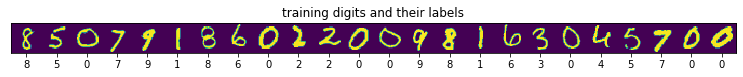

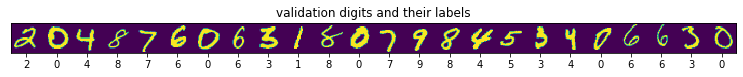

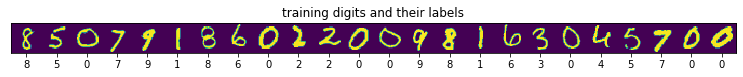

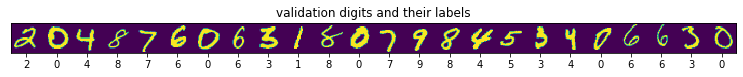

In [77]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
 
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)


# THE MODEL

* I used 3 blocks of convolution and 1 fully connected layers for the output
* Conv Block 1 outputs 12 feature maps without stride
* Conv Block 2 outputs 24 feature maps with stride of 2
* Conv Block 3 outputs 32 feature maps with stride of 2
* FC Flatten transforms the output of Conv Block 3 in to a vector
* FC Dense shrinks the vector
* FC Out drops other parts of the vector and shrinks it into size of 10 wich are the probability

* BatchNormalization - prevents overfitting
                     
                        - enables the usage of higher learning rates

* relu - used as the activation function for each layer except output 
       
           - this helps the network to converge faster during training
       
* softmax -used to bring up the highest values inside the array that means the highes probability.


In [78]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28,28,1)),

    # Conv Block 1
    tf.keras.layers.Conv2D(kernel_size=3, filters=12,  use_bias=False, padding='same'),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),

    # Conv Block 2
    tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),

    # Conv Block 3
    tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),
      
    # FC Flatten
    tf.keras.layers.Flatten(),

    # FC Dense 
    tf.keras.layers.Dense(200,use_bias=False),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation('relu'),

    # FC Out
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          2

# Learning Rate

* Scheduled Learning rate - This helps in making the training faster by setting the initial rate high
                          
                             - It will gradually reduce the learning rate for each epoch
                          
                             - Helps avoiding saddle points

In [79]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)


# TRAINING THE MODEL

* Steps per epoch -  helps training faster by feeding batches of data

                    - Calculated by **N_dataset//Batch_size**

* Epochs - I used 10 epochs for training


In [80]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay_callback])

Steps per epoch:  468
Train for 468 steps, validate for 1 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
468/468 [==============================] - 60s 129ms/step - loss: 0.1300 - accuracy: 0.9596 - val_loss: 0.0612 - val_accuracy: 0.9807

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00666.
Epoch 2/10
468/468 [==============================] - 56s 120ms/step - loss: 0.0477 - accuracy: 0.9858 - val_loss: 0.0434 - val_accuracy: 0.9865

Epoch 00003: LearningRateScheduler reducing learning rate to 0.004435560000000001.
Epoch 3/10
468/468 [==============================] - 57s 123ms/step - loss: 0.0279 - accuracy: 0.9914 - val_loss: 0.0538 - val_accuracy: 0.9819

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0029540829600000007.
Epoch 4/10
468/468 [==============================] - 56s 119ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0277 - val_accuracy: 0.9909

Epoch 00005: LearningRateScheduler reducing lea

In [81]:
model.save('MNIST_.63%_Carlo_Pastoral.h5')

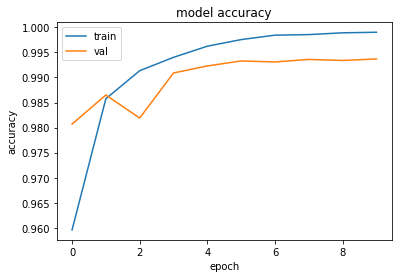

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

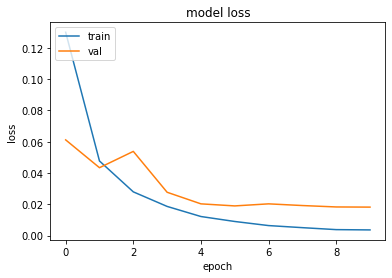

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

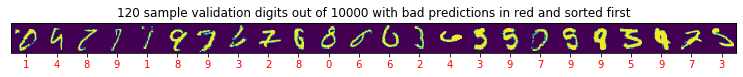

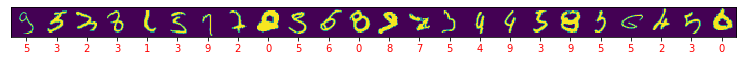

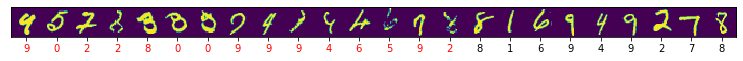

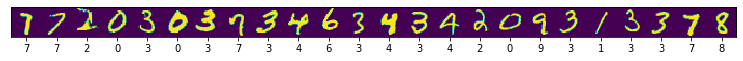

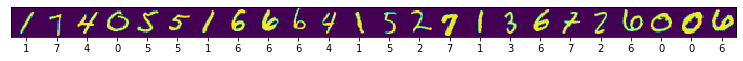

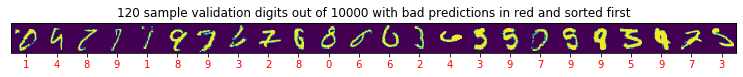

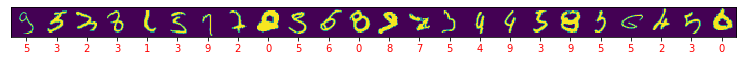

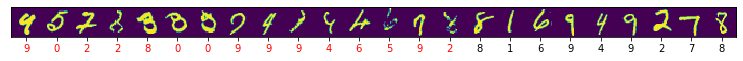

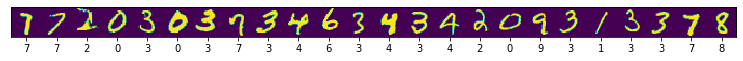

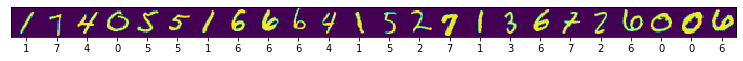

In [87]:
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, 24, 5)